In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate


data = pd.read_csv('C:/Users/Lenovo/Desktop/electronics.csv')
data.head(10)

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0
5,0,5,2.0,1999-07-12,Female,Portable Audio & Video,NaN,1999,NaN,0
6,0,6,5.0,1999-07-13,Female,Portable Audio & Video,NaN,1999,NaN,0
7,0,7,2.0,1999-07-13,Female,Portable Audio & Video,NaN,1999,NaN,0
8,0,8,4.0,1999-07-16,Female,Portable Audio & Video,NaN,1999,NaN,0
9,0,9,5.0,1999-08-20,Female,Portable Audio & Video,NaN,1999,NaN,0


In [2]:
data.item_id.value_counts()

7780    28530
2031     9393
1575     8622
2279     6278
2486     5810
        ...  
1529        1
3972        1
9555        1
9557        1
4253        1
Name: item_id, Length: 9560, dtype: int64

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='rating', ylabel='count'>

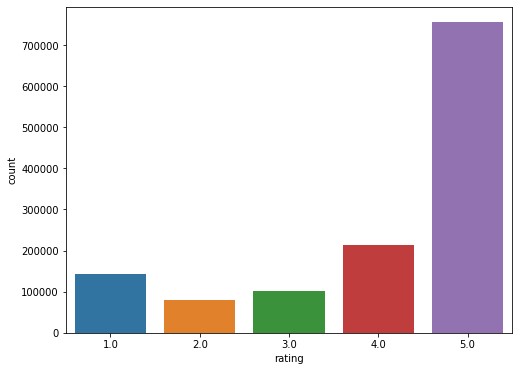

In [3]:
plt.figure(figsize=(8,6))
sns.countplot(data['rating'])

In [4]:
df_rating=pd.DataFrame({'Number of Rating':data.groupby('item_id').count()['rating'], 'Mean Rating':data.groupby('item_id').mean()['rating']})

In [5]:
df_rating.head()

,Number of Rating,Mean Rating
item_id,,
0,118,3.542373
1,58,3.844828
2,3404,4.464160
3,155,3.251613
4,11,3.636364


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Rating', ylabel='Density'>

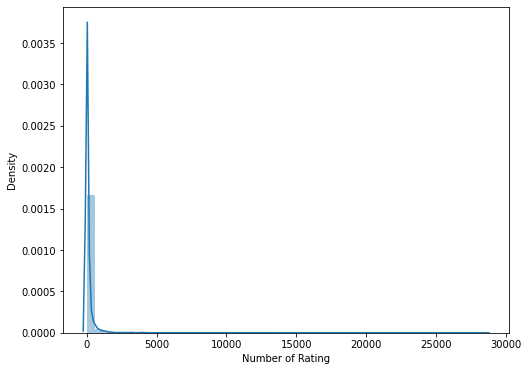

In [6]:
plt.figure(figsize=(8,6))
sns.distplot(df_rating['Number of Rating'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Mean Rating', ylabel='Density'>

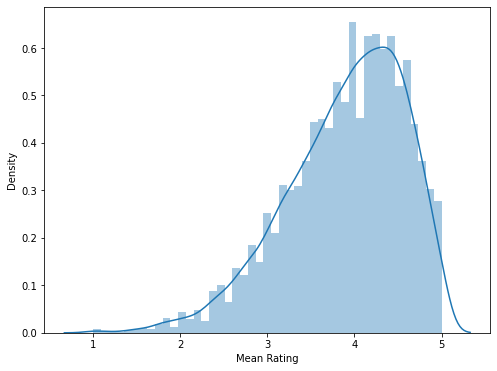

In [7]:
plt.figure(figsize=(8,6))
sns.distplot(df_rating['Mean Rating'])

<Figure size 576x432 with 0 Axes>

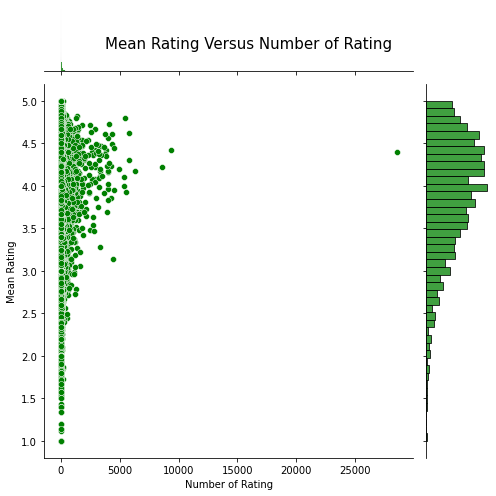

In [8]:
plt.figure(figsize=(8,6))
sns.jointplot(x='Number of Rating', y='Mean Rating',data=df_rating,color='g', height=7)
plt.suptitle('Mean Rating Versus Number of Rating', fontsize=15, y=0.92)

plt.show()

# Recommendation System

## Popularity-Based Recommender

The implementation of Popularity-Based Filtering is straighforward. All we have to do is sort our products based on ratings, and display the top products of our list. Therefore, we should;

- Create a metric to score or rate the products.
- Calculate the score for every product.
- Sort the scores and recommend the best rated product to the users.

We can use the average ratings of the products as the score but using this will not be fair enough since a product with 5average rating and only43 votes cannot be considered better than the product with 4 as average rating but 40 votes. So, we use IMDB's weighted rating formula to score the products, as follows:

Weighted Rating (WR) =  ((v/(v+m)) * R)+((m/(v+m)) * C) 

- v: the number of votes for the product

- m: the minimum votes required to be listed in the chart

- R: the average rating of the product

- C: the mean vote across the whole report

In [9]:
df_rating['Mean Rating'].mean()

3.8964310770267514

The mean rating for all the products (C) is approximately 3.9 on a scale of 5.

The next step is to determine an appropriate value for m, the minimum number of votes required for a product to be listed in the chart. We use 90th percentile as our cutoff. In other words, for a product to feature in the charts, the number of its votes should be higher than that of 90% of the products in the list.

In [10]:
df_rating['Number of Rating'].quantile(q=0.7)

66.0

In [11]:
df_filtered=df_rating[df_rating['Number of Rating']>df_rating['Number of Rating'].quantile(q=0.9)]

In [12]:
df_filtered.shape

(953, 2)

We see that there are 953 products which qualify to be in this list.

Now, we calculate score for each qualified product. To do this, we define a function, weighted_rating(), and apply this function to the DataFrame of qualified products.

In [13]:
def product_score(x):
    v=x['Number of Rating']
    m=df_rating['Number of Rating'].quantile(q=0.9)
    R=x['Mean Rating']
    C=df_rating['Mean Rating'].mean()
    return ((R*v)/(v+m))+((C*m)/(v+m))

In [14]:
df_filtered['score']=df_filtered.apply(product_score, axis=1)

C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df_filtered.head()

,Number of Rating,Mean Rating,score
item_id,,,
2,3404,4.464160,4.420441
17,1073,3.369991,3.480167
33,567,3.871252,3.879655
43,1923,4.298492,4.246754
79,661,4.508321,4.324430


Finally, we sort the dataframe based on the score feature, and we output the the top 10 popular products.

In [16]:
df_highscore=df_filtered.sort_values(by='score', ascending=False).head(10)

In [17]:
df_highscore

,Number of Rating,Mean Rating,score
item_id,,,
1715,5482,4.797337,4.752963
6818,4105,4.724970,4.671357
2016,1330,4.815789,4.654019
4968,1300,4.800769,4.638628
1470,2445,4.710429,4.625719
2514,1767,4.711941,4.599018
1706,2922,4.663244,4.595317
2340,5790,4.625734,4.591634
2483,4325,4.611329,4.567278


In [18]:
df_highscore.index

Int64Index([1715, 6818, 2016, 4968, 1470, 2514, 1706, 2340, 2483, 4718], dtype='int64', name='item_id')

So the top 10 popular products that this model will recommend to users include 1715, 6818, 2016, 4968, 1470, 2514, 1706, 2340, 2483, 4718.

## Collaborative Recommender

Our popularity-based recommender engine suffers from some severe limitations. It is not really personal and does not capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a product will receive the same recommendations for that product, regardless of who she/he is.

Collaborative Filtering matches persons with similar interests and provides recommendations based on this matching. It is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

Surprise library is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. Here we use the Surprise library that uses extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise Root Mean Square Error (RMSE) that is measured by Kfold Cross Validation and give great recommendations.

In [19]:
svd = SVD()
reader = Reader()

data1 = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

 we run 5-fold cross-validation and print the results.

In [20]:
#cross_validate(svd, data1, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [21]:
trainset = data1.build_full_trainset()
svd.fit(trainset)

## Hybrid Recommender

hybrid recommender combines corrwith() method which computes the Pearson correlation coefficients with collaborative filtering. This is how it works:

- Input: User ID and Product ID

- Output: Similar products sorted on the basis of expected ratings by a particular user.

First, we create a pivot table which contains userIds as rows and productIds as columns.

In [24]:
df_users=data.groupby('user_id').filter(lambda x: x['rating'].count()>=10)

In [25]:
df_users.head()

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
28,0,28,2.0,1999-12-01,Female,Portable Audio & Video,NaN,1999,Female,0
158,3,158,2.0,2000-08-05,Female,Camera & Photo,NaN,2005,NaN,0
183,14,158,4.0,2000-10-28,Female&Male,Camera & Photo,Kodak,2001,NaN,0
271,14,269,5.0,2001-03-02,Female&Male,Camera & Photo,Kodak,2001,Male,0
279,15,269,5.0,2001-03-10,Female&Male,Camera & Photo,Kodak,2006,Male,0


In [26]:
df_users.shape

(3007, 10)

In [27]:
matrix=pd.pivot_table(data=df_users, values='rating', index='user_id',columns='item_id')

In [28]:
matrix.head()

item_id,0,2,3,14,15,16,17,24,40,43,...,9327,9392,9406,9468,9484,9503,9504,9509,9510,9537
user_id,,,,,,,,,,,,,,,,,,,,,
28,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,NaN,NaN,2.0,4.0,NaN,3.0,NaN,5.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Function that takes in productId and useId as input and outputs up to 5 most similar products.
def hybrid_recommendations(userId, productId):
    
    # Get the Id of the top five products that are correlated with the ProductId chosen by the user.
    top_five=matrix.corrwith(matrix[productId]).sort_values(ascending=False).head(5)
    
    # Predict the ratings the user might give to these top 5 most correlated products.
    est_rating=[]
    for x in list(top_five.index):
        if str(top_five[x])!='nan':
            est_rating.append(svd.predict(userId, iid=x, r_ui=None).est)
           
    return pd.DataFrame({'productId':list(top_five.index)[:len(est_rating)], 'estimated_rating':est_rating}).sort_values(by='estimated_rating', ascending=False).reset_index(drop=True)

In [30]:
hybrid_recommendations(158,2)

C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,productId,estimated_rating
0,2,4.132082
1,1301,3.700137
